## Import Libraries

In [48]:
import numpy as np
import pandas as pd
from niapy.problems import Problem
from niapy.task import Task, OptimizationType
from niapy.algorithms.modified import HybridBatAlgorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt 

## Load Dataset

In [49]:
df_train = pd.read_excel('./data_set/boston_train.xlsx')
df_test = pd.read_excel('./data_set/boston_test.xlsx')

## Data Splitting

In [50]:
df_train_y = df_train['CHAS']
df_test_y = df_test['CHAS']

In [51]:
df_train = df_train.drop(columns=['CHAS'])
df_test = df_test.drop(columns=['CHAS'])
X = np.array(df_train)
y = np.array(df_train_y)

In [52]:
X_search, X_validate, y_search, y_validate = train_test_split(X, y, test_size=0.8, random_state=1234)
X_search_train, X_search_test, y_search_train, y_search_test = train_test_split(X_search, y_search, test_size=0.8, random_state=1234)

## Optimizer

In [53]:
def get_hyperparameters(x):
    """Get hyperparameters for solution `x`."""
    algorithms = ('ball_tree', 'kd_tree', 'brute')
    n_neighbors = int(5 + x[0] * 10)
    weights = 'uniform' if x[1] < 0.5 else 'distance'
    algorithm = algorithms[int(x[2] * 2)]
    leaf_size = int(10 + x[3] * 40)

    params =  {
        'n_neighbors': n_neighbors,
        'weights': weights,
        'algorithm': algorithm,
        'leaf_size': leaf_size
    }
    return params

In [54]:
def get_classifier(x):
    """Get classifier from solution `x`."""
    params = get_hyperparameters(x)
    return KNeighborsClassifier(**params)

In [55]:
class KNNHyperparameterOptimization(Problem):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(dimension=4, lower=0, upper=1)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def _evaluate(self, x):
        model = get_classifier(x)
        model.fit(self.X_train, self.y_train)
        return model.score(self.X_test, self.y_test)

Best parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 46}
default model mean accuracy: 0.9135365853658536
Best model mean accuracy: 0.9229166666666668


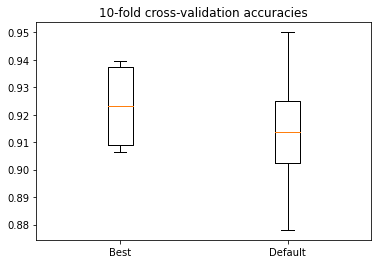

In [56]:
problem = KNNHyperparameterOptimization(X_search_train, X_search_test, y_search_train, y_search_test)
task = Task(problem, max_evals=100, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = HybridBatAlgorithm(population_size=40, differential_weight=0.8)

best_params, best_accuracy = algorithm.run(task)

print('Best parameters:', get_hyperparameters(best_params))

best_model = get_classifier(best_params)
default_model = KNeighborsClassifier()

default_scores = cross_val_score(default_model, X, y, cv=10, n_jobs=-1)
best_scores = cross_val_score(best_model, X_validate, y_validate, cv=10, n_jobs=-1)

print('default model mean accuracy:', default_scores.mean())
print('Best model mean accuracy:', best_scores.mean())

plt.boxplot([best_scores, default_scores], vert=True)
plt.xticks(ticks=[1, 2], labels=['Best', 'Default'])
plt.title('10-fold cross-validation accuracies')

plt.savefig('chart.png')